## Cryptocurrency Transactions Notebook

In this notebook, we read data on cryptocurrency assets and derive insights from it.

### Contents
1. [Coinhacko: Average transaction price of each asset](#section1)
2. [Coinhacko: Comparison with current asset price](#section2)
3. [Binance](#section3)

### 1 - Average transaction price of each asset <a name="section1"></a>

Reading the contents of each file generated by cryptocurrency exchange.

In [123]:
import pandas as pd
coinhako = pd.read_csv("transactions/01_Coinhako_Trade History.csv")

coinhako.head()

,Pair,Side,Type,Average Price,Price,Amount,Executed,Fee,Total,Status,Time & Date
0,DOT/SGD,Sell,Instant Order,--,59.476800,17.458356,--,6.230203,1032.140000,Completed,3/4/2021 22:28
1,UNI/SGD,Sell,Instant Order,--,34.513400,7.957171,--,2.197032,272.430000,Completed,22/2/2021 20:03
2,BAND/BTC,Swap,Instant Order,--,0.000291,5.721537,--,0.000013,0.001652,Completed,22/2/2021 16:56
3,LINK/BTC,Swap,Instant Order,--,0.000607,3.338482,--,0.000016,0.002010,Completed,21/2/2021 11:16
4,BTC/SGD,Buy,Instant Order,--,59607.590000,100.000000,--,0.800000,0.001664,Completed,11/2/2021 1:31


Let's visualise the transactions: see which is the more popular trading assets.

<AxesSubplot:ylabel='Pair'>

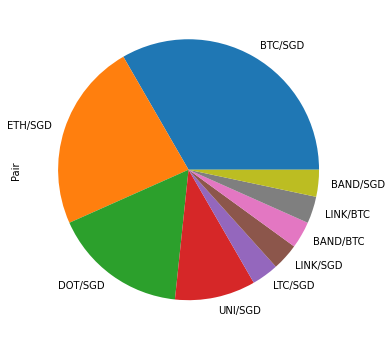

In [124]:
count = coinhako['Pair'].value_counts()
count.plot.pie(figsize=(6,6))

We get data for Buy/Sell transactions.

For this section, we will leave out the "Swap" data.

In [125]:
import numpy as np

coinhako_ = coinhako[coinhako['Side']!='Swap'].groupby(['Pair', 'Side']).agg({'Total':'sum', 'Amount':'sum', 'Fee':'sum'})
coinhako_.reset_index(inplace=True)
coinhako_['Fee (%)'] = (coinhako_['Fee']/coinhako_['Amount'])*100
coinhako_['Average Buying/Selling Price'] = np.where(coinhako_['Side']=='Buy', coinhako_['Amount']/coinhako_['Total'], coinhako_['Total']/coinhako_['Amount'])
coinhako_ = coinhako_.rename(columns={'Total': 'Total amount of asset purchased', 'Amount':'Total cost of asset purchased', 'Fee':'Total Fee'})
coinhako_['Current asset price'] = np.nan
coinhako_.head()

,Pair,Side,Total amount of asset purchased,Total cost of asset purchased,Total Fee,Fee (%),Average Buying/Selling Price,Current asset price
0,BAND/SGD,Buy,5.721537,100.000000,0.800000,0.800000,17.477823,NaN
1,BTC/SGD,Buy,0.038008,1730.000000,16.200000,0.936416,45517.015944,NaN
2,DOT/SGD,Buy,17.458356,400.000000,3.200000,0.800000,22.911664,NaN
3,DOT/SGD,Sell,1032.140000,17.458356,6.230203,35.686080,59.120113,NaN
4,ETH/SGD,Buy,0.693040,950.000000,9.300000,0.978947,1370.771985,NaN


### 2 - Comparision wth current asset price <a name="section2"></a>

In [126]:
import cryptocompare
price = cryptocompare.get_price('BAND', 'SGD')

def  get_crypto_price(asset):
    return cryptocompare.get_price(asset, 'SGD')[asset]['SGD']

print(get_crypto_price('BAND'))

26.25


In [127]:
coinhako_['Asset'] = coinhako_['Pair'].str.split("/", expand=True)[0]

for i in range(0, coinhako_.shape[0]):
    coinhako_['Current asset price'][i] = get_crypto_price(coinhako_['Asset'][i])
                          
coinhako_      

<ipython-input-127-94c9697e8382>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coinhako_['Current asset price'][i] = get_crypto_price(coinhako_['Asset'][i])


,Pair,Side,Total amount of asset purchased,Total cost of asset purchased,Total Fee,Fee (%),Average Buying/Selling Price,Current asset price,Asset
0,BAND/SGD,Buy,5.721537,100.000000,0.800000,0.800000,17.477823,26.25,BAND
1,BTC/SGD,Buy,0.038008,1730.000000,16.200000,0.936416,45517.015944,74659.19,BTC
2,DOT/SGD,Buy,17.458356,400.000000,3.200000,0.800000,22.911664,51.89,DOT
3,DOT/SGD,Sell,1032.140000,17.458356,6.230203,35.686080,59.120113,51.89,DOT
4,ETH/SGD,Buy,0.693040,950.000000,9.300000,0.978947,1370.771985,4511.51,ETH
5,LINK/SGD,Buy,3.338482,100.000000,0.800000,0.800000,29.953730,65.52,LINK
6,LTC/SGD,Buy,0.146176,30.000000,0.300000,1.000000,205.232323,467.14,LTC
7,UNI/SGD,Buy,7.957171,200.000000,1.600000,0.800000,25.134562,57.99,UNI
8,UNI/SGD,Sell,272.430000,7.957171,2.197032,27.610720,34.237044,57.99,UNI


### 3 - Binance <a name="section3"></a>

In [128]:
binance = pd.read_csv("transactions/05_Binance_Trade History.csv")

binance.head()

,Date(UTC),Pair,Side,Price,Executed,Amount,Fee
0,2021-04-27 08:47:14,MATICBUSD,SELL,0.6100000000,163.9000000000MATIC,99.97900000BUSD,0.0000000000BNB
1,2021-04-25 20:50:54,BTCBUSD,BUY,"48,500.0000000000",0.0010300000BTC,49.95500000BUSD,0.0000000000BNB
2,2021-04-22 20:27:24,BTCBUSD,BUY,"52,000.0000000000",0.0019230000BTC,99.99600000BUSD,0.0000000000BNB
3,2021-04-18 16:38:27,BTCBUSD,BUY,"55,700.0000000000",0.0017950000BTC,99.98150000BUSD,0.0000000000BNB
4,2021-04-18 09:03:12,ETHBUSD,BUY,"2,130.0000000000",0.0469400000ETH,99.98220000BUSD,0.0000000000BNB


Data is messy and improper form, we have to do some cleaning.

In [129]:
binance['Executed'] = binance.Executed.str.replace(r"[a-zA-Z,]",'')
binance['Amount'] = binance.Amount.str.replace(r"[a-zA-Z]",'')
binance['Fee'] = binance.Fee.str.replace(r"[a-zA-Z]",'')
binance['Executed'] = binance['Executed'].astype(float)
binance['Amount'] = binance['Amount'].astype(float)
binance['Fee'] = binance['Fee'].astype(float)

Similar to above, let us visualise the asset transaction preferences.

<AxesSubplot:>

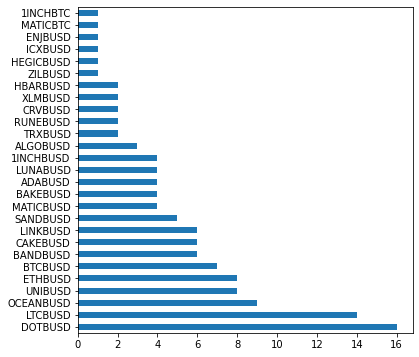

In [130]:
bi_count = binance['Pair'].value_counts()
bi_count.plot(kind='barh', figsize=(6,6))

In [131]:
binance_ = binance.groupby(['Pair', 'Side']).agg({'Amount':'sum', 'Executed':'sum', 'Fee':'sum'})
binance_.reset_index(inplace=True)
binance_['Fee (%)'] = (binance_['Fee']/binance_['Amount'])*100
binance_['Average Buying/Selling Price (USD)'] = binance_['Amount']/binance_['Executed']
binance_ = binance_.rename(columns={'Amount': 'Total cost of asset purchased (USD)', 'Executed':'Total Number of asset units', 'Fee':'Total Fee'})
binance_['Current asset price'] = np.nan
# coinhako_

In [132]:
#Get the Asset Pair
binance_['Asset'] = binance_['Pair'].apply(lambda x: x[:-4:] if x[-4:] == 'BUSD' else x[:-3])

for i in range(0, binance_.shape[0]):
    binance_['Current asset price'][i] = get_crypto_price(binance_['Asset'][i])


<ipython-input-132-97662fb20d24>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binance_['Current asset price'][i] = get_crypto_price(binance_['Asset'][i])


In [133]:
binance_['Paper Gain'] = np.where(binance_['Side'] == 'BUY', 
                        (binance_['Current asset price']*binance_['Total Number of asset units'])-binance_['Total cost of asset purchased (USD)'], 0)

def apply_formatting(col):
    if col.name == 'Side':
        return ['color: red' if c == "SELL" else 'color: green' for c in col.values]
    if col.name == 'Paper Gain':
        return ['color: green' if c > 0 else 'color:red' for c in col.values]

binance_.style.apply(apply_formatting, subset=['Side', 'Paper Gain'])

,Pair,Side,Total cost of asset purchased (USD),Total Number of asset units,Total Fee,Fee (%),Average Buying/Selling Price (USD),Current asset price,Asset,Paper Gain
0,1INCHBTC,SELL,0.001522,15.000000,0.000169,11.072578,0.000101,7.809000,1INCH,0.000000
1,1INCHBUSD,BUY,199.962000,47.610000,0.000000,0.000000,4.200000,7.809000,1INCH,171.824490
2,1INCHBUSD,SELL,99.990000,18.180000,0.000000,0.000000,5.500000,7.809000,1INCH,0.000000
3,ADABUSD,BUY,496.215000,475.800000,0.000000,0.000000,1.042907,1.845000,ADA,381.636000
4,ADABUSD,SELL,99.864000,65.700000,0.000000,0.000000,1.520000,1.845000,ADA,0.000000
5,ALGOBUSD,BUY,399.988450,300.180000,0.000000,0.000000,1.332495,1.899000,ALGO,170.053370
6,ALGOBUSD,SELL,99.992200,66.220000,0.000000,0.000000,1.510000,1.897000,ALGO,0.000000
7,BAKEBUSD,BUY,299.881565,269.250000,0.000000,0.000000,1.113766,8.409000,BAKE,1964.241685
8,BAKEBUSD,SELL,336.562500,269.250000,0.000000,0.000000,1.250000,8.409000,BAKE,0.000000
9,BANDBUSD,BUY,799.965550,60.498000,0.000000,0.000000,13.223008,26.250000,BAND,788.106950
